# LRC Resonance

### Date: 20/05/19 - 21/05/19
### Group Members: Aayushi Verma, Diana Kommedal, Alex Goodenbour

## Introduction

## Method

## Analysis

### Setup and helper function definition

In [185]:
# Setup and helper function definition

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
from scipy.optimize import minimize
from scipy.stats import chisquare
from decimal import Decimal

# Rounds uncertainties to one significant figure
def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))

# Model for a sinusoid
def model_w(params, w):
    I_max, w_0, gamma = params
    return (gamma*w*I_max)/np.sqrt(w**2*gamma**2+(w**2-w_0**2)**2)

# Not sure what the params should be...
def model_C(params, C):
    w = 553*2*np.pi
    R = 21.9014
    L = 0.1479
    V_0 = params
    return (V_0)/np.sqrt(R**2+(w*L-(1/(w*C)))**2)
    

# Function to compute chi-squared
# Last arg is an anonymous function to generalise
def chi2(params, data, model):
    
    x = data[:,0]
    y = data[:,1]
    #sigma = data [:,2]
    
    expected = model(params, x)
    return chisquare(y, expected)[0]

    
# Fits data points to sinusoidal model
# Example:  # params, unc = calc_model(guesses, np.column_stack((w, I)))
def calc_model(guesses, pnts, fn):
    result = minimize(chi2,guesses, method='BFGS',args=(pnts,fn))
    param_unc = np.sqrt(2*np.diag(result.hess_inv))
    newparams = result.x
    #print(newparams)
    return newparams, param_unc

def plot_model(xlow, xhigh, fn, params, label, lstyle="-", colour="c"):
    xx = np.linspace(xlow, xhigh, 1000)
    plt.plot(xx, fn(params, xx), linestyle=lstyle, color=colour, label=label)


# Unit conversion lambdas
in_to_cm = lambda x: 2.54*x

# Importing the data
data = pds.read_csv("lrc.csv")

### Inductance of a Coil

In [172]:
L_from_res = lambda w_0, C: 1/(w_0**2*C)
r_from_L = lambda N, L, M_0: (2*L)/(N**2*np.pi*M_0)

M_0 = np.pi*4e-7

C = 0.56e-6
w_0 = 553*2*np.pi
N = 1500
L_coil = L_from_res(w_0, C)
r_coil = r_from_L(N, L_coil, M_0)
print("Inductance of Coil:", round(L_coil,4), "H")
print("Radius of Coil: ", round(r_coil*1e2, 2), "cm")

Inductance of Coil: 0.1479 H
Radius of Coil:  3.33 cm


### Resonance Curves

I_max Experimental: 88.16 mA
w_0 Experimental: 552 Hz
Gamma Experimental: 148.07

Experimental Resistance: 21.9014 Ω

Experimental V_0:  1.92 V


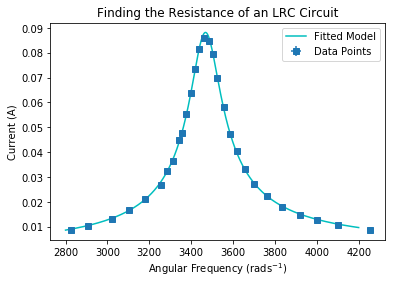

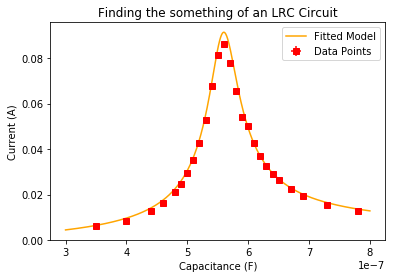

In [170]:
## For I(w) and I(C)

xx = np.linspace(0,10,1000)
#plt.plot(xx, model_w((1,1,1),xx))

w = np.array(data.frequency_w)*np.pi*2
w = w[~np.isnan(w)]
I = np.array(data.current_w)*1e-3
I = I[~np.isnan(I)]

guesses = (85e-3,3500,L_coil*1000)

params, unc = calc_model(guesses, np.column_stack((w,I)), model_w)
#print("Fitted Params: ", params)

plt.figure(1)

plot_model(2800, 4200, model_w, params, "Fitted Model")
plt.errorbar(w, I, 0, 0, linestyle="none", marker="s", label="Data Points")
plt.title("Finding the Resistance of an LRC Circuit")
plt.xlabel("Angular Frequency (rads$^{-1}$)")
plt.ylabel("Current (A)")
plt.legend()

[I_max_exp, w_0_exp, gamma_exp] = params
print("I_max Experimental:", round(Decimal(I_max_exp*1e3),2), "mA")
print("w_0 Experimental:", round(Decimal(w_0_exp/(2*np.pi)),0), "Hz")
print("Gamma Experimental:", round(Decimal(gamma_exp),2))
print()
R_exp = gamma_exp*L_coil
print("Experimental Resistance:", round(R_exp,4), "Ω")


plt.figure(2)

cap = np.array(data.cap_c)*1e-6
cap = cap[~np.isnan(cap)]
I_c = np.array(data.current_c)*1e-3
I_c = I_c[~np.isnan(I_c)]

guesses = (2)

params, unc = calc_model(guesses, np.column_stack((cap,I_c)), model_C)
#print("Fitted Params: ", params)

plot_model(0.0000003, 0.0000008, model_C, guesses, "Fitted Model", colour="orange")
plt.errorbar(cap, I_c, 0, 0, linestyle="none", marker="s", color="r", label="Data Points")
plt.title("Finding the something of an LRC Circuit")
plt.xlabel("Capacitance (F)")
plt.ylabel("Current (A)")
print()
print("Experimental V_0: ", round(Decimal(params[0]),2), "V")
plt.legend()

### Determination of $Q$

In [164]:
## From Q = V_C / V_S
## and from Q = w_0/gamma from fitted params

Q_exp_1 = data.v_c[0]/data.v_s[0]
Q_exp_2 = w_0_exp/gamma_exp

print("Experimental Q from Voltage Ratio:", round(Q_exp_1,2))
print("Experimental Q from fitted values:", round(Q_exp_2,2))

Experimental Q from Voltage Ratio: 22.65
Experimental Q from fitted values: 23.42


### Altering $Q$ by Adding Resistance

Total Resistance needed in circuit: 102.60
Resistance Needed in Variable Resistor: 80.70
Gamma Experimental: 677.25

Experimental Resistance: 100.17 Ω
Experimental Quality Factor: 5.12


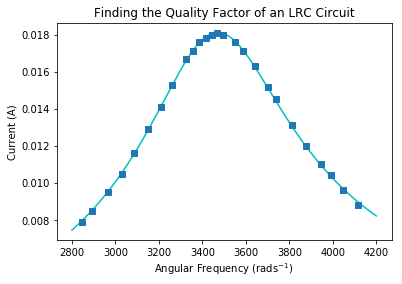

In [183]:
R_5 = (w_0_exp*L_coil)/5
print("Total Resistance needed in circuit:", round(Decimal(R_5),2))
R_var_res = R_5-R_exp
print("Resistance Needed in Variable Resistor:", round(Decimal(R_var_res),2))

w_5 = np.array(data.freq_5)*np.pi*2
w_5 = w_5[~np.isnan(w_5)]
I_5 = np.array(data.current_5)*1e-3
I_5 = I_5[~np.isnan(I_5)]

guesses = (0.02,3500,L_coil*1000)

params5, unc = calc_model(guesses, np.column_stack((w_5,I_5)), model_w)
#print("Fitted Params: ", params)

#plt.figure(1)

plot_model(2800, 4200, model_w, params5, "Fitted Model")
plt.errorbar(w_5, I_5, 0, 0, linestyle="none", marker="s", label="Data Points")
plt.title("Finding the Quality Factor of an LRC Circuit")
plt.xlabel("Angular Frequency (rads$^{-1}$)")
plt.ylabel("Current (A)")

[I_max_exp_5, w_0_exp_5, gamma_exp_5] = params5

Q_exp_5 = w_0_exp_5/gamma_exp_5

print("Gamma Experimental:", round(Decimal(gamma_exp_5),2))
print()
R_exp_5 = gamma_exp_5*L_coil
print("Experimental Resistance:", round(Decimal(R_exp_5),2), "Ω")
print("Experimental Quality Factor:", round(Decimal(Q_exp_5),2))

###  Resonant Frequency of a Lossy Resonant Circuit

In [188]:
w_d_109 = data.f_109[0]*2*np.pi
v_c_109 = data.v_c_109[0]

w_0_109 = w_d_109*np.sqrt(1+(1/2*Q_exp_5)**2)

observed_difference = np.abs(w_d_109-w_0_exp_5)
print(observed_difference)

27.515425451984356


## Discussion

## Conclusion